In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from multiprocessing import cpu_count
from multiprocessing import Pool

## 병렬처리에 사용될 코드

In [2]:
num_cores = cpu_count()

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

## Demographics 데이터 - ID 별 성별과 HbA1c 정보 포함

In [3]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


## 추후 Feature extraction에 이용될 feature 계산 함수

In [4]:
###### ACC
# 가속도 벡터 magnitude
def calculate_mag(acc_x, acc_y, acc_z):
    acc_mag = np.sqrt(acc_x ** 2 + acc_y ** 2 + acc_z ** 2)
    return acc_mag

###### Activity bouts
def exercisepts(acc, hr, time): #acc and hr must be same length
    
    exercisepoints = []
    for z in range(len(acc)):
        if acc.iloc[z] > np.mean(acc.iloc[0:z]):
            if hr.iloc[z] > np.mean(hr.iloc[0:z]):
                exercisepoints.append(1)
            else:
                exercisepoints.append(0)
        else:
            exercisepoints.append(0)
            
    returndf = pd.DataFrame()
    returndf['datetime'] = time
    returndf['Activity Bouts'] = exercisepoints
    
    countbouts = len(exercisepoints)
    return countbouts, returndf

###### EDA
def peak_eda(eda):
    peaks_idx, properties = find_peaks(eda, height=0, distance=4, prominence=0.3)
    peak_eda = len(peaks_idx)
    return peak_eda

# PersHigh, PersLow, PersNorm 분류 함수
def classify_glucose(value, mean, std):
    if value > mean + std:
        return 'PersHigh'
    elif value < mean - std:
        return 'PersLow'
    else:
        return 'PersNorm'
    
###### IBI
def nn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    nn50 = round(n,1)
    return nn50

def pnn50(ibi):
    differences = abs(np.diff(ibi))
    n = np.sum(differences > 50)
    p=0
    if len(differences) != 0:
        p = (n / len(differences)) * 100
    pnn50 = round(p, 1)
    return pnn50

def rmssd(ibi):
    differences = abs(np.diff(ibi))
    rmssd = 0
    if len(differences) != 0:
        rmssd = np.sqrt(np.sum(np.square(differences)) / len(differences))
    rmssd = round(rmssd,1)
    return rmssd

def sdnn(ibi):
    if ibi.isnull().any():
        return np.nan
    #return round(np.sqrt(np.var(ibi, ddof=1)) * 10) / 10
    return round(np.sqrt(np.var(ibi, ddof=1)), 1)


## EXTENDED HRV FEATURES

def sdsd(ibi):
    if len(ibi) < 2:
        return np.nan
    return np.std(np.diff(ibi))

def cvnn(ibi):
    if len(ibi) == 0 or ibi.isnull().any() or sdnn(ibi) == 0 or np.isnan(sdnn(ibi)):
        return np.nan
    return np.mean(ibi) / sdnn(ibi)

def cvsd(ibi):
    if len(ibi) == 0 or ibi.isnull().any() or np.isnan(np.mean(ibi)):
        return np.nan
    return sdsd(ibi) / np.mean(ibi)

def mcvnn(ibi):
    if len(ibi) < 2 or ibi.isnull().any():
        return np.nan
    differences = abs(np.diff(ibi))
    return np.median(np.abs(differences - np.median(differences)))

def iqrnn(ibi):
    if len(ibi) == 0 or ibi.isnull().any():
        return np.nan
    return np.percentile(ibi, 75) - np.percentile(ibi, 25)

def sdrmssd(ibi):
    if len(ibi) == 0 or ibi.isnull().any() or rmssd(ibi) == 0 or np.isnan(rmssd(ibi)) or sdnn(ibi) == 0 or np.isnan(sdnn(ibi)):
        return np.nan
    return sdnn(ibi) / rmssd(ibi)

def prc20nn(ibi):
    if len(ibi) == 0:
        return np.nan
    return np.percentile(ibi, 20)

def prc80nn(ibi):
    if len(ibi) == 0:
        return np.nan
    return np.percentile(ibi, 80)

def tinn(ibi):
    if len(ibi) == 0:
        return np.nan
    hist, bin_edges = np.histogram(ibi, bins='auto')
    return bin_edges[-1] - bin_edges[0]

def hti(ibi):
    if len(ibi) == 0 or ibi.isnull().any():
        return np.nan
    hist, _ = np.histogram(ibi, bins='auto')
    if max(hist) == 0:
        return np.nan
    return max(hist)



###### circaidan rhythm
def crhythm(time, timeformat='%Y-%m-%d %H:%M:%S'):
    
    df = pd.DataFrame()
    df['Time'] =  pd.to_datetime(time, format=timeformat)
    df['Timefrommidnight'] =  df['Time'].dt.time
    hourfrommid=[]
    minfrommid=[]
    
    for i in range(0, len(df['Timefrommidnight'])):
        if pd.isna(df['Timefrommidnight'].iloc[i]):
            minfrommid.append(0)
            hourfrommid.append(0)
        else:
            minfrommid.append(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))
            hourfrommid.append(round((int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))/60))

    return hourfrommid, minfrommid


# Wake Time을 감지하는 함수를 정의합니다.
'''
def detect_wake_time(df, slope_threshold = 0.5):
    wake_times = pd.Series(0, index=df.index)
    for current_time in df.index:
        past_time = current_time - pd.Timedelta(minutes=75)
        if past_time < df.index[0]:  # 시작 시간 이전이면 무시
            continue
        else:
            closest_past_time = df.index.asof(past_time)
            slope = (df.loc[current_time, 'Rolling_HR_Mean'] - df.loc[closest_past_time, 'Rolling_HR_Mean']) / 15 # / 75
            if slope > slope_threshold:
                wake_times.loc[current_time] = 1
    return wake_times
'''

def detect_wake_time(processed_data, short_window=25, long_window=75):
    # Identifying wake time
    wake_times = pd.Series(0, index=processed_data.index)
    unique_days = processed_data.index.normalize().unique()

    for day in unique_days:
        day_data = processed_data[processed_data.index.normalize() == day]
        if not day_data.empty:
            smoothed_binary = day_data['rolling_avg']
            start_time = day_data.index[0]
            end_time = day_data.index[-1]
            
            
            idx = 0
            current_time = day_data.index[idx]
            while current_time + pd.Timedelta(minutes=long_window) <= end_time:
                short_term_window_end = current_time + pd.Timedelta(minutes=short_window)
                long_term_window_end = current_time + pd.Timedelta(minutes=long_window)

                rolling_slope = processed_data.loc[current_time, 'rolling_slope']

                if np.abs(rolling_slope) > 0 and (smoothed_binary.loc[short_term_window_end:long_term_window_end] > smoothed_binary.loc[current_time]).all():
                    wake_times.loc[current_time] = 1
                    #break

                idx += 1  # Move the window by one minute
                current_time = day_data.index[idx]

    return wake_times

### 특정 날짜 인덱스가 주어질 때, 데이터셋의 유효한 인덱스 중 가장 가까운 인덱스를 반환 (데이터포인트 지정에 사용)
예를 들어, CGM이 5분 간격으로 기록된다고 해도 실제로는 정확한 5분 차이가 아니라 1~2초 오차가 있을 수 있다. 이때, 정확한 시간 계산으로 윈도우 슬라이싱을 하려고 한다면, 1초 차이로 데이터포인트가 제외될 수 있기 때문에 시간 계산 후, 가장 가까운 값을 찾는 방식을 사용한다.

In [5]:
def find_nearest_index(index, target):
    """
    Find the nearest index in a sorted DatetimeIndex to a target timestamp.
    Args:
        index (pd.DatetimeIndex): Sorted DatetimeIndex.
        target (pd.Timestamp): Target timestamp.
    Returns:
        pd.Timestamp: Nearest timestamp in the index to the target.
    """
    if len(index) == 0:
        raise ValueError("The provided index is empty.")
    
    filtered_index = index[(index >= target - pd.Timedelta('5m')) & (index <= target + pd.Timedelta('5m'))]

    if len(filtered_index) == 0:
        return target

    nearest_index = min(filtered_index, key=lambda x: abs(x - target))
    return nearest_index

## Glycemic Variability 관련 지표 계산 함수

See:
Normal Reference Range for Mean Tissue Glucose and Glycemic Variability Derived from Continuous Glucose Monitoring for Subjects Without Diabetes in Different Ethnic Groups
Nathan R. Hill, Nick S. Oliver, Pratik Choudhary, Jonathan C. Levy, Peter Hindmarsh, and David R. Matthews
Diabetes Technology & Therapeutics 2011 13:9, 921-928

Code from: 
https://github.com/DigitalBiomarkerDiscoveryPipeline/cgmquantify.git

* MAGE
* Average daily risk ratio (ADRR)
* J-Index
* Low Blood Glucose Index and High Blood Glucose Index (LBGI & HBGI)
* Continuous overlapping net glycemic action (COGNA)
    * Paper : https://www.liebertpub.com/doi/10.1089/dia.2005.7.253?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub++0pubmed
* Mean of daily differences (MODD)

In [6]:
def MAGE(df, std=1):
    """
        Computes and returns the mean amplitude of glucose excursions
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            sd (integer): standard deviation for computing range (default=1)
        Returns:
            MAGE (float): the mean amplitude of glucose excursions 
        Refs:
            Sneh Gajiwala: https://github.com/snehG0205/NCSA_genomics/tree/2bfbb87c9c872b1458ef3597d9fb2e56ac13ad64
            
    """
        
    #extracting glucose values and incdices
    glucose = df['glucose'].tolist()
    ix = [1*i for i in range(len(glucose))]
    stdev = std
    
    # local minima & maxima
    a = np.diff(np.sign(np.diff(glucose))).nonzero()[0] + 1      
    # local min
    valleys = (np.diff(np.sign(np.diff(glucose))) > 0).nonzero()[0] + 1 
    # local max
    peaks = (np.diff(np.sign(np.diff(glucose))) < 0).nonzero()[0] + 1         
    # +1 -- diff reduces original index number

    #store local minima and maxima -> identify + remove turning points
    excursion_points = pd.DataFrame(columns=['Index', 'time', 'glucose', 'type'])
    k=0
    for i in range(len(peaks)):
        excursion_points.loc[k] = [peaks[i]] + [df['time'].iloc[k]] + [df['glucose'].iloc[k]] + ["P"]
        k+=1

    for i in range(len(valleys)):
        excursion_points.loc[k] = [valleys[i]] + [df['time'].iloc[k]] + [df['glucose'].iloc[k]] + ["V"]
        k+=1

    excursion_points = excursion_points.sort_values(by=['Index'])
    excursion_points = excursion_points.reset_index(drop=True)


    # selecting turning points
    turning_points = pd.DataFrame(columns=['Index', 'time', 'glucose', 'type'])
    k=0
    for i in range(stdev,len(excursion_points.Index)-stdev):
        positions = [i-stdev,i,i+stdev]
        for j in range(0,len(positions)-1):
            if(excursion_points.type[positions[j]] == excursion_points.type[positions[j+1]]):
                if(excursion_points.type[positions[j]]=='P'):
                    if excursion_points.glucose[positions[j]]>=excursion_points.glucose[positions[j+1]]:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1
                    else:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1
                else:
                    if excursion_points.glucose[positions[j]]<=excursion_points.glucose[positions[j+1]]:
                        turning_points.loc[k] = excursion_points.loc[positions[j]]
                        k+=1
                    else:
                        turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                        k+=1

    if len(turning_points.index)<10:
        turning_points = excursion_points.copy()
        excursion_count = len(excursion_points.index)
    else:
        excursion_count = len(excursion_points.index)/2


    turning_points = turning_points.drop_duplicates(subset= "Index", keep= "first")
    turning_points=turning_points.reset_index(drop=True)
    excursion_points = excursion_points[excursion_points.Index.isin(turning_points.Index) == False]
    excursion_points = excursion_points.reset_index(drop=True)

    # calculating MAGE
    mage = turning_points.glucose.sum()/excursion_count
    
    return round(mage,3)


def ADRR(df):
    """
        Computes and returns the average daily risk range, an assessment of total daily glucose variations within risk space
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            ADRRx (float): average daily risk range
            
    """
    ADRRl = []
    for i in pd.unique(df['Day']):
        LBGI, HBGI, rh, rl = LBGI_HBGI(df[df['Day']==i])
        LR = np.max(rl)
        HR = np.max(rh)
        ADRRl.append(LR+HR)

    ADRRx = np.mean(ADRRl)
    return ADRRx


def J_index(df):
    """
        Computes and returns the J-index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            J (float): J-index of glucose
            
    """
    J = 0.001*((np.mean(df['glucose'])+np.std(df['glucose']))**2)
    return J


def LBGI_HBGI(df):
    """
        Connecter function to calculate rh and rl, used for ADRR function
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            LBGI (float): Low blood glucose index
            HBGI (float): High blood glucose index
            rl (float): See calculation of LBGI
            rh (float): See calculation of HBGI
            
    """
    f = ((np.log(df['glucose'])**1.084) - 5.381)
    rl = []
    for i in f: 
        if (i <= 0):
            rl.append(22.77*(i**2))
        else:
            rl.append(0)

    LBGI = np.mean(rl)

    rh = []
    for i in f: 
        if (i > 0):
            rh.append(22.77*(i**2))
        else:
            rh.append(0)

    HBGI = np.mean(rh)
    
    return LBGI, HBGI, rh, rl

def LBGI(df):
    """
        Computes and returns the low blood glucose index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            LBGI (float): Low blood glucose index
            
    """
    f = ((np.log(df['glucose'])**1.084) - 5.381)
    rl = []
    for i in f: 
        if (i <= 0):
            rl.append(22.77*(i**2))
        else:
            rl.append(0)

    LBGI = np.mean(rl)
    return LBGI

def HBGI(df):
    """
        Computes and returns the high blood glucose index
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Returns:
            HBGI (float): High blood glucose index
            
    """
    f = ((np.log(df['glucose'])**1.084) - 5.381)
    rh = []
    for i in f: 
        if (i > 0):
            rh.append(22.77*(i**2))
        else:
            rh.append(0)

    HBGI = np.mean(rh)
    return HBGI


def uniquevalfilter(df, value):
    """
        Supporting function for MODD and CONGA24 functions
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
            value (datetime): time to match up with previous 24 hours
        Returns:
            MODD_n (float): Best matched with unique value, value
            
    """
    xdf = df[df['Minfrommid'] == value]
    
    n = len(xdf)
    diff = abs(xdf['glucose'].diff())

    MODD_n = np.nanmean(diff)
    
    return MODD_n

def MODD(df):
    """
        Computes and returns the mean of daily differences. Examines mean of value + value 24 hours before
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Requires:
            uniquevalfilter (function)
        Returns:
            MODD (float): Mean of daily differences
            
    """
    df['Timefrommidnight'] =  df['time'].dt.time
    lists=[]
    for i in range(0, len(df['Timefrommidnight'])):
        lists.append(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))
    df['Minfrommid'] = lists
    df = df.drop(columns=['Timefrommidnight'])
    
    #Calculation of MODD and CONGA:
    MODD_n = []
    uniquetimes = df['Minfrommid'].unique()

    for i in uniquetimes:
        MODD_n.append(uniquevalfilter(df, i))
    
    #Remove zeros from dataframe for calculation (in case there are random unique values that result in a mean of 0)
    MODD_n[MODD_n == 0] = np.nan
    
    MODD = np.nanmean(MODD_n)
    return MODD

def CONGA24(df): # 최소 48시간 분량 glucose 데이터포인트 필요
    """
        Computes and returns the continuous overall net glycemic action over 24 hours
        Args:
            (pd.DataFrame): dataframe of data with DateTime, Time and Glucose columns
        Requires:
            uniquevalfilter (function)
        Returns:
            CONGA24 (float): continuous overall net glycemic action over 24 hours
            
    """
    df['Timefrommidnight'] =  df['time'].dt.time
    lists=[]
    for i in range(0, len(df['Timefrommidnight'])):
        lists.append(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[0:2])*60 + int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[3:5]) + round(int(df['Timefrommidnight'].iloc[i].strftime('%H:%M:%S')[6:9])/60))
    df['Minfrommid'] = lists
    df = df.drop(columns=['Timefrommidnight'])
    
    #Calculation of MODD and CONGA:
    MODD_n = []
    uniquetimes = df['Minfrommid'].unique()

    for i in uniquetimes:
        MODD_n.append(uniquevalfilter(df, i))

    print(len(MODD_n))
    print()
    print(f'MODD_n: {MODD_n}')
    
    #Remove zeros from dataframe for calculation (in case there are random unique values that result in a mean of 0)
    MODD_n[MODD_n == 0] = np.nan
    
    #print(MODD_n)
    CONGA24 = np.nanstd(MODD_n)
    return CONGA24


### 24.08.02 ADDED - GJLee
def CONGAn(df, n): # n Hours 전의 glucose 데이터와의 차이 값들의 표준편차

    duplicates = df.index[df.index.duplicated()]
    if len(duplicates) > 0:
        print('duplicates')
        print(duplicates)

    dt_list = []
    for timestamp in df.index:
        window_start = timestamp - pd.Timedelta(hours=n)
        window_end = timestamp 
        
        if window_start < df.index[0] - pd.Timedelta('1m'):
            continue
        
        window_start = find_nearest_index(df.index, window_start)

        # D 계산
        dt = df.loc[window_end, 'glucose'] - df.loc[window_start, 'glucose']
        if isinstance(dt, pd.Series):
            print('isseries - window')
            print(window_start.strftime('%Y-%m-%d %H:%M:%S'))
            print(window_end.strftime('%Y-%m-%d %H:%M:%S'))
            continue

        dt_list.append(dt)

    dt_array = np.array(dt_list)
    return np.std(dt_array)
    
        

## Feature 정보들과 대응되는 Target 값들을 담는 데이터프레임 칼럼

In [7]:
# 빈 DataFrame 생성
df = pd.DataFrame(columns=[
    'calories2hr',
    'protein2hr',
    'sugar2hr',
    'carbs2hr',
    'calories8hr',
    'protein8hr',
    'sugar8hr',
    'carbs8hr',
    'calories24hr',
    'protein24hr',
    'sugar24hr',
    'carbs24hr',
    'eat',
    'eatcnt2hr',
    'eatcnt8hr',
    'eatcnt24hr',
    'eatmean2hr',
    'eatmean8hr',
    'eatmean24hr',
    'acc_mean',
    'acc_std',
    'acc_min',
    'acc_max',
    'acc_q1g',
    'acc_q3g',
    'acc_skew',
    'acc_mean_2hrs',
    'acc_max_2hrs',
    'eda_mean',
    'eda_std',
    'eda_min',
    'eda_max',
    'eda_q1g',
    'eda_q3g',
    'eda_skew',
    'PeakEDA',
    'PeakEDA2hr_sum',
    'PeakEDA2hr_mean',
    'hr_mean',
    'hr_std',
    'hr_min',
    'hr_max',
    'hr_q1g',
    'hr_q3g',
    'hr_skew',
    'maxHRV',
    'minHRV',
    'medianHRV',
    'meanHRV',
    'SDNN',
    'NN50',
    'pNN50',
    'RMSSD',
    'SDSD', #
    'CVNN', #
    'MCVNN', #
    'SDRMSSD', #
    'TINN', #
    #'HTI',
    'temp_mean',
    'temp_std',
    'temp_min',
    'temp_max',
    'temp_q1g',
    'temp_q3g',
    'temp_skew',
    'Activity_bouts',
    'Activity24',
    'Activity1hr',
    'Minfrommid',
    'Hourfrommid',
    'carbs2hr_ratio',
    'protein2hr_ratio',
    'sugar2hr_ratio',
    'elapsed_minutes_intake',
    # Glycemic Variability Metrics
    'MAGE',
    'CONGA1',
    'CONGA2',
    'CONGA4',
    'CONGA8',
    'J_index',
    'HBGI',
    'LBGI',
])

## Dataset 관련 Warnings

* 003 데이터셋 Food_Log에 칼럼 누락되어 있음 추가 필요 (단, time_end 칼럼은 없어야 하며, 뒷부분의 4개 칼럼은 {calorie,total_carb,sugar,protein}으로 구성됨).
* 001 데이터셋의 HR 대해서 datetime 포맷이 다름 (hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')).
* 012 데이터셋 Food_Log의 마지막 행에 데이터 누락됨.
    ~~~
    2020-05-11,07:00:00,,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    -> 2020-05-11,07:00:00,2020-05-11 07:00:00,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    ~~~
* 013 데이터셋 Food_Log의 date와 datetime 포맷이 다름.

## 중요 Warnings - 처리한 시간 범주 불일치 문제 (Food Log 와 CGM 기록의 시간 범주 일치성 확인)

7번 참가자 Food log 날짜가 일치하지 않음.  
  
덱스콤 실제 데이터 범위  
2020-03-14 12:42:19  
2020-03-22 11:06:57  
  
Food Log  
10/16/2019 13:44  
10/24/2019 8:30  
  
-----------------------------------------------
12번 참가자 5월 3일, 4일 데이터가 포함되지 않음.
  
-----------------------------------------------
13번 참가자 Food log 날짜가 일치하지 않음.  
  
덱스콤 활용 데이터 범위. 5일  
Start: 2020-05-30 15:41:50  
End: 2020-06-04 12:11:40  
  
Food Log 범위. 8일  
12/30/2019 16:30  
1/6/2020 9:30  
  
-----------------------------------------------
15번 참가자 Food log 날짜가 범위에서 벗어남.  
  
덱스콤 활용 데이터 범위.  
Start: 2020-07-21 22:28:52  
End: 2020-07-25 11:33:48  
  
덱스콤 실제 데이터 범위.  
2020-07-19 17:33:52  
2020-07-27 10:38:46  
  
Food Log  
2020-02-17 10:00:00  
2020-02-25 07:30:00  

## 일별 범주 확인 및 범주가 맞지 않는 일자 제거 함수

In [8]:
def validate_daily_dfs(daily_dfs):
    diff_set = set()
    accset = set()
    edaset = set()
    hrset = set()
    ibiset = set()
    tempset = set()
    dexcomset = set()
    for idx in range(len(daily_dfs['acc'])):
        accset = accset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date))
    for idx in range(len(daily_dfs['eda'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date))
    for idx in range(len(daily_dfs['hr'])):
        hrset = hrset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date))
    for idx in range(len(daily_dfs['ibi'])):
        ibiset = ibiset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date))
    for idx in range(len(daily_dfs['temp'])):
        tempset = tempset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date))
    for idx in range(len(daily_dfs['dexcom'])):
        dexcomset = dexcomset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date))
    ## 차집합 연산 : 하나라도 예외적인 다른 날짜가 있다면 제외시켜야 함.
    diff_set = diff_set.union(dexcomset.difference(accset))
    diff_set = diff_set.union(dexcomset.difference(edaset))
    diff_set = diff_set.union(dexcomset.difference(hrset))
    diff_set = diff_set.union(dexcomset.difference(ibiset))
    diff_set = diff_set.union(dexcomset.difference(tempset))
    print(f'Exclude date: {diff_set}')

    if len(diff_set) > 0:
        ## diffset의 date값을 갖고 있는 daily_dfs 딕셔너리 내 value 의 리스트 원소(데이터프레임)를 제거
        if len(diff_set & accset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['acc'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['acc'] = [daily_dfs['acc'][i] for i in range(len(daily_dfs['acc'])) if i not in indexes_to_remove]

        if len(diff_set & edaset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['eda'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['eda'] = [daily_dfs['eda'][i] for i in range(len(daily_dfs['eda'])) if i not in indexes_to_remove]

        if len(diff_set & hrset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['hr'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['hr'] = [daily_dfs['hr'][i] for i in range(len(daily_dfs['hr'])) if i not in indexes_to_remove]

        if len(diff_set & ibiset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['ibi'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['ibi'] = [daily_dfs['ibi'][i] for i in range(len(daily_dfs['ibi'])) if i not in indexes_to_remove]

        if len(diff_set & tempset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['temp'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['temp'] = [daily_dfs['temp'][i] for i in range(len(daily_dfs['temp'])) if i not in indexes_to_remove]
        
        if len(diff_set & dexcomset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['dexcom'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['dexcom'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['dexcom'] = [daily_dfs['dexcom'][i] for i in range(len(daily_dfs['dexcom'])) if i not in indexes_to_remove]

        return False, daily_dfs
    return True, daily_dfs

## CGM 결측치에 대한 처리 함수 - linear interpolate

In [9]:
def cgm_interpolate(dexcom_df):
    # 시간 간격 계산
    dexcom_df['time_diff'] = dexcom_df.index.to_series().diff().dt.total_seconds() / 60.0

    # 결측치에 대해 NaN을 삽입
    # 4분에서 6분 사이가 아닌 시간 간격을 찾기
    new_rows = []
    for i in range(1, len(dexcom_df)):
        if dexcom_df['time_diff'].iloc[i] > 6 or dexcom_df['time_diff'].iloc[i] < 4:
            num_missing = int(dexcom_df['time_diff'].iloc[i] // 5)  # 5분 간격으로 결측값 삽입
            for j in range(1, num_missing + 1):
                missing_time = dexcom_df.index[i-1] + pd.Timedelta(minutes=5*j)
                if missing_time not in dexcom_df.index:
                    new_rows.append(pd.DataFrame({'glucose': [np.nan]}, index=[missing_time]))

    # 새로 생성된 행을 기존 데이터프레임에 추가
    if new_rows:
        new_rows_df = pd.concat(new_rows)
        dexcom_df = pd.concat([dexcom_df, new_rows_df]).sort_index()

    # 시간순으로 정렬
    dexcom_df.sort_index(inplace=True)

    # 보간 전 결측값 구간 출력
    #print(f"[ID {id}] 보간 전 결측값이 있는 구간:")
    #print(dexcom_df[dexcom_df['glucose'].isnull()])

    # 다양한 보간법 사용 (선형 보간을 예시로 사용)
    dexcom_df['glucose'] = dexcom_df['glucose'].interpolate(method='linear')

    dexcom_df.drop(columns=['time_diff'], inplace=True)

    # 보간 후 결측값 구간 출력
    #print("\n[ID {id}] 보간 후 결측값이 있는 구간:")
    #print(dexcom_df[dexcom_df['glucose'].isnull()])

    duplicates = dexcom_df.index[dexcom_df.index.duplicated()]
    if len(duplicates) > 0:
        print('dexcom_df duplicates')
        print(duplicates)
        print(f'count : {duplicates.value_counts()}')
        duplicate_glucose_values = dexcom_df.loc[duplicates, 'glucose']
        print("\nGlucose values for duplicate datetime indices:")
        print(duplicate_glucose_values)

    return dexcom_df


## 본격적인 Preprocessing & Feature Extraction 작업

In [10]:
exclude_first24hr = False # 첫 24시간 데이터를 포함할 것인지 제외할 것인지.
ibimultiplier = 1000 # Transform ibi to milliseconds

In [11]:
for id in range(1, len(dg_df)+1):
    if id == 15: # Skip ID 15
        continue
    fl_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Food_Log_{id:03}.csv')
    acc_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/ACC_{id:03}.csv')
    eda_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/EDA_{id:03}.csv')
    #bvp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/BVP_{id:03}.csv')
    hr_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/HR_{id:03}.csv')
    ibi_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/IBI_{id:03}.csv')
    temp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/TEMP_{id:03}.csv')
    dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

    biological_sex = dg_df.loc[dg_df['ID'] == id, 'Gender'].values[0]
    hbA1c = dg_df.loc[dg_df['ID'] == id, 'HbA1c'].values[0]

    print(f'[ID: {id}] Now processing ...')

    ## datetime 변환 및 리샘플링 전처리
    ## Dexcom Glucose
    dexcom_df.drop(dexcom_df.loc[:11].index, inplace=True)
    dexcom_df.rename(columns = {'Timestamp (YYYY-MM-DDThh:mm:ss)': 'datetime'}, inplace = True)
    dexcom_df.rename(columns = {'Glucose Value (mg/dL)': 'glucose'}, inplace = True)
    dexcom_df = dexcom_df[['datetime', 'glucose']]
    dexcom_df['datetime']=pd.to_datetime(dexcom_df['datetime'])
    dexcom_df.set_index('datetime', inplace=True)

    ## CGM 결측치 보간
    dexcom_df = cgm_interpolate(dexcom_df)

    ## Food Log
    if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
    else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])


    ## Food Log 시간 범위 조정 - 불일치 문제 해결
    if id == 7:
        new_start = pd.Timestamp("2020-03-14 13:44:00")
        old_start = pd.Timestamp("2019-10-16 13:44:00")
        # 시간 차이 계산
        time_difference = new_start - old_start
        # 시간 범위 조정
        fl_df['time_begin'] = fl_df['time_begin'] + time_difference
    elif id == 13:
        new_start = pd.Timestamp("2020-05-28 16:30:00")
        old_start = pd.Timestamp("2019-12-30 16:30:00")
        # 시간 차이 계산
        time_difference = new_start - old_start
        # 시간 범위 조정
        fl_df['time_begin'] = fl_df['time_begin'] + time_difference
    elif id == 16:
        new_start = pd.Timestamp("2020-07-17 06:30:00")
        old_start = pd.Timestamp("2020-02-21 06:30:00")
        # 시간 차이 계산
        time_difference = new_start - old_start
        # 시간 범위 조정
        fl_df['time_begin'] = fl_df['time_begin'] + time_difference
        # 2020-07-17일 이전의 데이터 자르기 - Food Log 부재
        cutoff_date = pd.Timestamp('2020-07-17')
        dexcom_df = dexcom_df[dexcom_df.index >= cutoff_date]
    
        
    fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
    fl_df = fl_df.sort_index()
    
    ## Accelerometer
    acc_df['datetime']=pd.to_datetime(acc_df['datetime'])
    acc_df['vector_mag'] = calculate_mag(acc_df[' acc_x'], acc_df[' acc_y'], acc_df[' acc_z'])
    acc_df.drop(columns=[' acc_x', ' acc_y', ' acc_z'], inplace=True)
    acc_resampled = pd.DataFrame()
    acc_resampled['ACC_Mean'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').mean().interpolate(method='time')
    acc_resampled['ACC_Std'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').std().interpolate(method='time')
    acc_resampled['ACC_Min'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').min().interpolate(method='time')
    acc_resampled['ACC_Max'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').max().interpolate(method='time')
    acc_resampled['ACC_Q1G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.25).interpolate(method='time')
    acc_resampled['ACC_Q3G'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').quantile(0.75).interpolate(method='time')
    acc_resampled['ACC_Skew'] = acc_df.set_index('datetime')['vector_mag'].resample('5Min').apply(lambda x: x.skew()).interpolate(method='time')
    
    ## EDA
    eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
    eda_resampled = pd.DataFrame()
    eda_resampled['EDA_Mean'] = eda_df.set_index('datetime')[' eda'].resample('5Min').mean().interpolate(method='time')
    eda_resampled['EDA_Std'] = eda_df.set_index('datetime')[' eda'].resample('5Min').std().interpolate(method='time')
    eda_resampled['EDA_Min'] = eda_df.set_index('datetime')[' eda'].resample('5Min').min().interpolate(method='time')
    eda_resampled['EDA_Max'] = eda_df.set_index('datetime')[' eda'].resample('5Min').max().interpolate(method='time')
    eda_resampled['EDA_Q1G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.25).interpolate(method='time')
    eda_resampled['EDA_Q3G'] = eda_df.set_index('datetime')[' eda'].resample('5Min').quantile(0.75).interpolate(method='time')
    eda_resampled['EDA_Skew'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: eda.skew()).interpolate(method='time')
    eda_resampled['peakEDA'] = eda_df.set_index('datetime')[' eda'].resample('5Min').apply(lambda eda: peak_eda(eda)).interpolate(method='time')
    ## Heart Rate
    if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
    else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
    hr_resampled = pd.DataFrame()
    hr_resampled['HR_Mean'] = hr_df.set_index('datetime')[' hr'].resample('5Min').mean().interpolate(method='time')
    hr_resampled['HR_Std'] = hr_df.set_index('datetime')[' hr'].resample('5Min').std().interpolate(method='time')
    hr_resampled['HR_Min'] = hr_df.set_index('datetime')[' hr'].resample('5Min').min().interpolate(method='time')
    hr_resampled['HR_Max'] = hr_df.set_index('datetime')[' hr'].resample('5Min').max().interpolate(method='time')
    hr_resampled['HR_Q1G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.25).interpolate(method='time')
    hr_resampled['HR_Q3G'] = hr_df.set_index('datetime')[' hr'].resample('5Min').quantile(0.75).interpolate(method='time')
    hr_resampled['HR_Skew'] = hr_df.set_index('datetime')[' hr'].resample('5Min').apply(lambda hr: hr.skew()).interpolate(method='time')
    
    ## Temperature
    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    temp_resampled = pd.DataFrame()
    temp_resampled['TEMP_Mean'] = temp_df.set_index('datetime')[' temp'].resample('5Min').mean().interpolate(method='time')
    temp_resampled['TEMP_Std'] = temp_df.set_index('datetime')[' temp'].resample('5Min').std().interpolate(method='time')
    temp_resampled['TEMP_Min'] = temp_df.set_index('datetime')[' temp'].resample('5Min').min().interpolate(method='time')
    temp_resampled['TEMP_Max'] = temp_df.set_index('datetime')[' temp'].resample('5Min').max().interpolate(method='time')
    temp_resampled['TEMP_Q1G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.25).interpolate(method='time')
    temp_resampled['TEMP_Q3G'] = temp_df.set_index('datetime')[' temp'].resample('5Min').quantile(0.75).interpolate(method='time')
    temp_resampled['TEMP_Skew'] = temp_df.set_index('datetime')[' temp'].resample('5Min').apply(lambda temp: temp.skew()).interpolate(method='time')
    
    ## IBI
    ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    #ibi_df[' ibi'] = ibi_df[' ibi'].interpolate(method='time')
    ibi_df[' ibi'] = ibi_df[' ibi'] * ibimultiplier # 초 -> 밀리초 단위로
    #ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    ibi_resampled = pd.DataFrame()
    ibi_resampled['minHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').min().interpolate(method='time')
    ibi_resampled['maxHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').max().interpolate(method='time')
    ibi_resampled['medianHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').median().interpolate(method='time')
    ibi_resampled['meanHRV'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').mean().interpolate(method='time')
    ibi_resampled['SDNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdnn(ibi)).interpolate(method='time')
    ibi_resampled['NN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: nn50(ibi)).interpolate(method='time')
    ibi_resampled['pNN50'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: pnn50(ibi)).interpolate(method='time')
    ibi_resampled['RMSSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: rmssd(ibi)).interpolate(method='time')
    
    ibi_resampled['SDSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdsd(ibi)).interpolate(method='time')
    ibi_resampled['CVNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: cvnn(ibi)).interpolate(method='time')
    ibi_resampled['CVSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: cvsd(ibi)).interpolate(method='time')
    ibi_resampled['MCVNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: mcvnn(ibi)).interpolate(method='time')
    # ibi_resampled['IQRNN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: iqrnn(ibi)).interpolate(method='time')
    ibi_resampled['SDRMSSD'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: sdrmssd(ibi)).interpolate(method='time')
    #ibi_resampled['Prc20NN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: prc20nn(ibi)).interpolate(method='time')
    #ibi_resampled['Prc80NN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: prc80nn(ibi)).interpolate(method='time')
    ibi_resampled['TINN'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: tinn(ibi)).interpolate(method='time')
    #ibi_resampled['HTI'] = ibi_df.set_index('datetime')[' ibi'].resample('5Min').apply(lambda ibi: hti(ibi)).interpolate(method='time')

    ## 날짜를 기준으로 데이터프레임을 분할하여 리스트에 저장
    daily_dfs = {'fl':[], 'acc':[], 'eda':[], 'hr':[], 'ibi':[], 'temp':[], 'bvp':[], 'dexcom':[]}
    for name, group in dexcom_df.groupby(dexcom_df.index.date):
        daily_dfs['dexcom'].append(group)
    for name, group in fl_df.groupby(fl_df['time_begin'].dt.date):
        daily_dfs['fl'].append(group)
    for name, group in acc_resampled.groupby(acc_resampled.index.date):
        daily_dfs['acc'].append(group)
    for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['eda'].append(group)
    for name, group in hr_resampled.groupby(hr_resampled.index.date):
        daily_dfs['hr'].append(group)
    for name, group in ibi_resampled.groupby(ibi_resampled.index.date):
        daily_dfs['ibi'].append(group)
    for name, group in temp_resampled.groupby(temp_resampled.index.date):
        daily_dfs['temp'].append(group)

    isok, daily_dfs = validate_daily_dfs(daily_dfs=daily_dfs)
    if isok == False:
        print(f'daily_dfs is modified...')
        
    base_df = pd.concat(daily_dfs['dexcom'])
    
    ## *_df 이름의 데이터프레임으로 리뉴얼

    acc_df.drop(acc_df.index, inplace=True)
    eda_df.drop(eda_df.index, inplace=True)
    hr_df.drop(hr_df.index, inplace=True)
    ibi_df.drop(ibi_df.index, inplace=True)
    temp_df.drop(temp_df.index, inplace=True)

    if len(daily_dfs['acc']) > 0:
        acc_df = pd.concat(daily_dfs['acc'])
    if len(daily_dfs['eda']) > 0:
        eda_df = pd.concat(daily_dfs['eda'])
    if len(daily_dfs['hr']) > 0:   
        hr_df = pd.concat(daily_dfs['hr'])
    if len(daily_dfs['ibi']) > 0:
        ibi_df = pd.concat(daily_dfs['ibi'])
    if len(daily_dfs['temp']) > 0:
        temp_df = pd.concat(daily_dfs['temp'])
    
    ###### activitybouts
    print(f'len acc == hr : {len(acc_df) == len(hr_df)}')
    if len(acc_df) != len(hr_df):
        print(f"acc : {acc_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {acc_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(acc_df)}")
        print(f"hr : {hr_df.index[0].strftime('%Y-%m-%d %H:%M:%S')} ~ {hr_df.index[-1].strftime('%Y-%m-%d %H:%M:%S')} : {len(hr_df)}")
        # Get the intersection of the indices
        common_index = acc_df.index.intersection(hr_df.index)
        # Filter both dataframes to only include the common indices
        acc_df = acc_df.loc[common_index]
        hr_df = hr_df.loc[common_index]
        print(f'After preprocessing-> len acc == hr : {len(acc_df) == len(hr_df)}')

    resultlen , returndf = exercisepts(acc_df['ACC_Mean'], hr_df['HR_Mean'], acc_df.index)
    acc_df['Activity_bouts'] = returndf['Activity Bouts'].values


    ## 윈도우 크기 설정
    window_size = '24h'

    if exclude_first24hr:
        base_df = base_df.loc[base_df.index[0] + pd.Timedelta('24h'):] ## 24.07.19 - 첫 24시간은 대상에서 제외 (CGM이 첫날은 부정확)

    ## 각 타임스탬프에 대해 롤링 윈도우 계산 (현재 timestamp 이전 데이터들로부터 feature extraction)
    for timestamp in base_df.index:
        # 현재 처리하는 지점
        current_point_index = timestamp

        ## 이전 데이터만 활용하여 feature extraction
        #window_end = timestamp - pd.Timedelta('1ns')
        window_end = find_nearest_index(base_df.index, timestamp - pd.Timedelta('5m')) # Previous datapoint index from current (prediction target) datapoint
        # feature 계산 대상 윈도우의 시작 지점
        window_start = window_end - pd.Timedelta(window_size)
        # 1 minute는 허용 오차
        if window_start < base_df.index[0] - pd.Timedelta('1m'):
            continue

        # 가장 가까운 값의 인덱스
        window_start = find_nearest_index(base_df.index, window_start)

        if window_start >= base_df.index[0] - pd.Timedelta('1m') and window_start < base_df.index[1]:
            print(f'[ID: {id}]Starting window')
            print(f"[ID: {id}] window_start: {window_start.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"[ID: {id}] window_end: {window_end.strftime('%Y-%m-%d %H:%M:%S')}")

        # df_glucose의 롤링 윈도우 범위 내의 데이터 선택
        glucose_window = base_df.loc[window_start:window_end, ['glucose']].copy()
        
        # df_other의 동일한 범위 내의 데이터 선택
        fl_window = fl_df.loc[window_start:window_end]
        acc_window = acc_df.loc[window_start:window_end]
        eda_window = eda_df.loc[window_start:window_end]
        hr_window = hr_df.loc[window_start:window_end]
        ibi_window = ibi_df.loc[window_start:window_end]
        temp_window = temp_df.loc[window_start:window_end]
        
        # glucose_window를 명시적으로 복사본으로 생성
        for_gv = glucose_window.copy()
        # 복사본 데이터프레임에서 작업
        for_gv['time'] = glucose_window.index

        #print(glucose_window.isna().sum())
        #print(for_gv.isna().sum())
        #print(for_gv.head())
        

        ##### Wake Time
        # 1. 현재 값이 Historical 평균보다 작은지 확인
        hr_historical = hr_window
        acc_historical = acc_window
        hr_mean_avg = hr_historical['HR_Mean'].mean()
        hr_std_avg = hr_historical['HR_Std'].mean()
        acc_mean_avg = acc_historical['ACC_Mean'].mean()
        acc_std_avg = acc_historical['ACC_Std'].mean()
        

        # 해당 날짜의 데이터 필터링 및 평균 계산
        '''
        specific_date = timestamp.date()
        hr_daily = hr_df[hr_df.index.date == specific_date]
        acc_daily = acc_df[hr_df.index.date == specific_date]
        
        hr_mean_avg = hr_daily.loc[:window_end]['HR_Mean'].mean()
        hr_std_avg = hr_daily.loc[:window_end]['HR_Std'].mean()
        acc_mean_avg = acc_daily.loc[:window_end]['ACC_Mean'].mean()
        acc_std_avg = acc_daily.loc[:window_end]['ACC_Std'].mean()
        '''
        
        base_df.loc[current_point_index, 'points'] = (
            (hr_window.iloc[-1]['HR_Mean'] < hr_mean_avg).astype(int) +
            (hr_window.iloc[-1]['HR_Std'] < hr_std_avg).astype(int) +
            (acc_window.iloc[-1]['ACC_Mean'] < acc_mean_avg).astype(int) +
            (acc_window.iloc[-1]['ACC_Std'] < acc_std_avg).astype(int)
        ) # 하루의 평균보다 작은 것의 개수

        # 2. 하루의 평균보다 작은 것의 개수가 2보다 크면 0 값을 할당합니다.
        base_df.loc[current_point_index, 'binary'] = (base_df.loc[current_point_index, 'points'] < 2).astype(int)

        # 3시간 동안의 데이터를 이동 평균(rolling)으로 계산합니다.
        # 데이터가 5분 간격이라고 가정하면, 3시간은 36 interval입니다.
        rolling_window3hr = base_df.loc[find_nearest_index(base_df.index, window_end - pd.Timedelta('3h')):window_end]
        base_df.loc[current_point_index, 'rolling_avg'] = rolling_window3hr['binary'].mean()
        base_df.loc[current_point_index, 'Rolling_HR_Mean'] = hr_df.loc[find_nearest_index(hr_df.index, window_end - pd.Timedelta('3h')):window_end]['HR_Mean'].mean()
        

        ##### fl

        calories2hr = 0.
        protein2hr = 0.
        sugar2hr = 0.
        carbs2hr = 0.
        calories8hr = 0.
        protein8hr = 0.
        sugar8hr = 0.
        carbs8hr = 0.
        calories24hr = 0.
        protein24hr = 0.
        sugar24hr = 0.
        carbs24hr = 0.
        
        flwindow5min = fl_window[find_nearest_index(fl_window.index, window_end - pd.Timedelta('5m')) : window_end]
        flwindow2hr = fl_window[find_nearest_index(fl_window.index, window_end - pd.Timedelta('2h')) : window_end]
        flwindow8hr = fl_window[find_nearest_index(fl_window.index, window_end - pd.Timedelta('8h')) : window_end]
        flwindow24hr = fl_window[find_nearest_index(fl_window.index, window_end - pd.Timedelta('24h')) : window_end]

        
        eat = 0
        if len(flwindow5min) > 0:
            eat = 1
        eatcnt2hr = len(flwindow2hr)
        eatcnt8hr = len(flwindow8hr)
        eatcnt24hr = len(flwindow24hr)

        eatmean2hr = eatcnt2hr / (2 * 60 / 5)  # 2시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean8hr = eatcnt8hr / (8 * 60 / 5)  # 8시간 동안 5분 간격으로 나눈 시간 간격 수
        eatmean24hr = eatcnt24hr / (24 * 60 / 5)  # 24시간 동안 5분 간격으로 나눈 시간 간격 수
        
        calories2hr = flwindow2hr['calorie'].values.sum()
        protein2hr = flwindow2hr['protein'].values.sum()
        sugar2hr = flwindow2hr['sugar'].values.sum()
        carbs2hr = flwindow2hr['total_carb'].values.sum()
        
        calories8hr = flwindow8hr['calorie'].values.sum()
        protein8hr = flwindow8hr['protein'].values.sum()
        sugar8hr = flwindow8hr['sugar'].values.sum()
        carbs8hr = flwindow8hr['total_carb'].values.sum()
        
        calories24hr = fl_window['calorie'].values.sum()
        protein24hr = fl_window['protein'].values.sum()
        sugar24hr = fl_window['sugar'].values.sum()
        carbs24hr = fl_window['total_carb'].values.sum()


        carbs2hr_ratio = 0.
        protein2hr_ratio = 0.
        sugar2hr_ratio = 0.
        if (round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)) != 0:
            carbs2hr_ratio = round(round(carbs2hr,2)/(round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)), 2)
            protein2hr_ratio = round(round(protein2hr,2)/(round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)), 2)
            sugar2hr_ratio = round(round(sugar2hr,2)/(round(carbs2hr,2) + round(protein2hr,2) + round(sugar2hr,2)), 2)
        
        elapsed_minutes = (current_point_index - window_start).total_seconds() / 60
        if len(flwindow24hr) > 0:
            last_intake = flwindow24hr.iloc[-1]['time_begin']
            elapsed_time = current_point_index - last_intake
        # 분 단위로 변환
        elapsed_minutes = elapsed_time.total_seconds() / 60
        
        ###### acc
        accwindow2hr = acc_window[find_nearest_index(acc_window.index, window_end - pd.Timedelta('2h')) : window_end]
        accwindow1hr = acc_window[find_nearest_index(acc_window.index, window_end - pd.Timedelta('1h')) : window_end]

        acc_mean_2hrs = accwindow2hr['ACC_Mean'].values.mean()
        acc_max_2hrs = accwindow2hr['ACC_Max'].values.max()

        activity24 = acc_window['Activity_bouts'].values.mean()
        activity1hr = accwindow1hr['Activity_bouts'].values.sum()

        ###### eda

        # peak detection
        edawindow2hr = eda_window[find_nearest_index(eda_window.index, window_end - pd.Timedelta('2h')) : window_end]# - pd.Timedelta('5m')]

        peakEDA2hr_sum = edawindow2hr['peakEDA'].values.sum()
        peakEDA2hr_mean = edawindow2hr['peakEDA'].values.mean()

        ##### results
        #print(f"(end of window): {window_end}, glucose: {glucose_window['glucose']}, sugar24hr: {sugar24hr}")
        # df_glucose의 개인화된 평균 및 표준 편차 계산 -> Class를 나누는 값 계산
        #print(f"[{window_start.strftime('%Y-%m-%d %H:%M:%S')} ~ {window_end.strftime('%Y-%m-%d %H:%M:%S')}] ID: {id}, sugar24hr: {sugar24hr}, glucose: {base_df.loc[window_end, 'glucose']}")
        base_df.loc[current_point_index, 'datetime'] = current_point_index.strftime('%Y-%m-%d %H:%M:%S')
        base_df.loc[current_point_index, 'personalMean'] = glucose_window['glucose'].mean()
        base_df.loc[current_point_index, 'personalStd'] = glucose_window['glucose'].std()
        base_df.loc[current_point_index, 'ID']=id
        base_df.loc[current_point_index, 'HbA1c']=hbA1c
        base_df.loc[current_point_index, 'Biological Sex']=biological_sex
        base_df.loc[current_point_index, 'calories2hr']=round(calories2hr,2)
        base_df.loc[current_point_index, 'protein2hr']=round(protein2hr,2)
        base_df.loc[current_point_index, 'sugar2hr']=round(sugar2hr,2)
        base_df.loc[current_point_index, 'carbs2hr']=round(carbs2hr,2)
        base_df.loc[current_point_index, 'calories8hr']=round(calories8hr,2)
        base_df.loc[current_point_index, 'protein8hr']=round(protein8hr,2)
        base_df.loc[current_point_index, 'sugar8hr']=round(sugar8hr,2)
        base_df.loc[current_point_index, 'carbs8hr']=round(carbs8hr,2)
        base_df.loc[current_point_index, 'calories24hr']=round(calories24hr,2)
        base_df.loc[current_point_index, 'protein24hr']=round(protein24hr,2)
        base_df.loc[current_point_index, 'sugar24hr']=round(sugar24hr,2)
        base_df.loc[current_point_index, 'carbs24hr']=round(carbs24hr,2)
        base_df.loc[current_point_index, 'eat']=eat
        base_df.loc[current_point_index, 'eatcnt2hr']=round(eatcnt2hr,2)
        base_df.loc[current_point_index, 'eatcnt8hr']=round(eatcnt8hr,2)
        base_df.loc[current_point_index, 'eatcnt24hr']=round(eatcnt24hr,2)
        base_df.loc[current_point_index, 'eatmean2hr']=round(eatmean2hr,2)
        base_df.loc[current_point_index, 'eatmean8hr']=round(eatmean8hr,2)
        base_df.loc[current_point_index, 'eatmean24hr']=round(eatmean24hr,2)
        base_df.loc[current_point_index, 'acc_mean']=round(acc_window.iloc[-1]['ACC_Mean'],2)
        base_df.loc[current_point_index, 'acc_std']=round(acc_window.iloc[-1]['ACC_Std'],2)
        base_df.loc[current_point_index, 'acc_min']=round(acc_window.iloc[-1]['ACC_Min'],2)
        base_df.loc[current_point_index, 'acc_max']=round(acc_window.iloc[-1]['ACC_Max'],2)
        base_df.loc[current_point_index, 'acc_q1g']=round(acc_window.iloc[-1]['ACC_Q1G'],2)
        base_df.loc[current_point_index, 'acc_q3g']=round(acc_window.iloc[-1]['ACC_Q3G'],2)
        base_df.loc[current_point_index, 'acc_skew']=round(acc_window.iloc[-1]['ACC_Skew'],2)
        base_df.loc[current_point_index, 'acc_mean_2hrs']=round(acc_mean_2hrs,2)
        base_df.loc[current_point_index, 'acc_max_2hrs']=round(acc_max_2hrs,2)
        base_df.loc[current_point_index, 'eda_mean']=round(eda_window.iloc[-1]['EDA_Mean'],2)
        base_df.loc[current_point_index, 'eda_std']=round(eda_window.iloc[-1]['EDA_Std'],2)
        base_df.loc[current_point_index, 'eda_min']=round(eda_window.iloc[-1]['EDA_Min'],2)
        base_df.loc[current_point_index, 'eda_max']=round(eda_window.iloc[-1]['EDA_Max'],2)
        base_df.loc[current_point_index, 'eda_q1g']=round(eda_window.iloc[-1]['EDA_Q1G'],2)
        base_df.loc[current_point_index, 'eda_q3g']=round(eda_window.iloc[-1]['EDA_Q3G'],2)
        base_df.loc[current_point_index, 'eda_skew']=round(eda_window.iloc[-1]['EDA_Skew'],2)
        base_df.loc[current_point_index, 'PeakEDA']=eda_window.iloc[-1]['peakEDA']
        base_df.loc[current_point_index, 'PeakEDA2hr_sum']=round(peakEDA2hr_sum,2)
        base_df.loc[current_point_index, 'PeakEDA2hr_mean']=round(peakEDA2hr_mean,2)
        base_df.loc[current_point_index, 'hr_mean']=round(hr_window.iloc[-1]['HR_Mean'],2)
        base_df.loc[current_point_index, 'hr_std']=round(hr_window.iloc[-1]['HR_Std'],2)
        base_df.loc[current_point_index, 'hr_min']=round(hr_window.iloc[-1]['HR_Min'],2)
        base_df.loc[current_point_index, 'hr_max']=round(hr_window.iloc[-1]['HR_Max'],2)
        base_df.loc[current_point_index, 'hr_q1g']=round(hr_window.iloc[-1]['HR_Q1G'],2)
        base_df.loc[current_point_index, 'hr_q3g']=round(hr_window.iloc[-1]['HR_Q3G'],2)
        base_df.loc[current_point_index, 'hr_skew']=round(hr_window.iloc[-1]['HR_Skew'],2)
        base_df.loc[current_point_index, 'maxHRV']=round(ibi_window.iloc[-1]['maxHRV'],2)
        base_df.loc[current_point_index, 'minHRV']=round(ibi_window.iloc[-1]['minHRV'],2)
        base_df.loc[current_point_index, 'medianHRV']=round(ibi_window.iloc[-1]['medianHRV'],2)
        base_df.loc[current_point_index, 'meanHRV']=round(ibi_window.iloc[-1]['meanHRV'],2)
        base_df.loc[current_point_index, 'SDNN']=round(ibi_window.iloc[-1]['SDNN'],2)
        base_df.loc[current_point_index, 'NN50']=round(ibi_window.iloc[-1]['NN50'],2)
        base_df.loc[current_point_index, 'pNN50']=round(ibi_window.iloc[-1]['pNN50'],2)
        base_df.loc[current_point_index, 'RMSSD']=round(ibi_window.iloc[-1]['RMSSD'],2)
        base_df.loc[current_point_index, 'SDSD']=round(ibi_window.iloc[-1]['SDSD'],2)
        base_df.loc[current_point_index, 'CVNN']=round(ibi_window.iloc[-1]['CVNN'],2)
        base_df.loc[current_point_index, 'CVSD']=round(ibi_window.iloc[-1]['CVSD'],2)
        base_df.loc[current_point_index, 'MCVNN']=round(ibi_window.iloc[-1]['MCVNN'],2)
        base_df.loc[current_point_index, 'SDRMSSD']=round(ibi_window.iloc[-1]['SDRMSSD'],2)
        base_df.loc[current_point_index, 'TINN']=round(ibi_window.iloc[-1]['TINN'],2)
        base_df.loc[current_point_index, 'temp_mean']=round(temp_window.iloc[-1]['TEMP_Mean'],2)
        base_df.loc[current_point_index, 'temp_std']=round(temp_window.iloc[-1]['TEMP_Std'],2)
        base_df.loc[current_point_index, 'temp_min']=round(temp_window.iloc[-1]['TEMP_Min'],2)
        base_df.loc[current_point_index, 'temp_max']=round(temp_window.iloc[-1]['TEMP_Max'],2)
        base_df.loc[current_point_index, 'temp_q1g']=round(temp_window.iloc[-1]['TEMP_Q1G'],2)
        base_df.loc[current_point_index, 'temp_q3g']=round(temp_window.iloc[-1]['TEMP_Q3G'],2)
        base_df.loc[current_point_index, 'temp_skew']=round(temp_window.iloc[-1]['TEMP_Skew'],2)
        base_df.loc[current_point_index, 'Activity_bouts']=acc_window.iloc[-1]['Activity_bouts']
        base_df.loc[current_point_index, 'Activity24']=activity24
        base_df.loc[current_point_index, 'Activity1hr']=activity1hr
        base_df.loc[current_point_index, 'carbs2hr_ratio']=carbs2hr_ratio
        base_df.loc[current_point_index, 'protein2hr_ratio']=protein2hr_ratio
        base_df.loc[current_point_index, 'sugar2hr_ratio']=sugar2hr_ratio
        base_df.loc[current_point_index, 'elapsed_minutes_intake']=elapsed_minutes
        # Glycemic Variability
        base_df.loc[current_point_index, 'MAGE'] = round(MAGE(for_gv), 2)
        base_df.loc[current_point_index, 'CONGA1'] = round(CONGAn(for_gv, 1), 2)
        base_df.loc[current_point_index, 'CONGA2'] = round(CONGAn(for_gv, 2), 2)
        base_df.loc[current_point_index, 'CONGA4'] = round(CONGAn(for_gv, 4), 2)
        base_df.loc[current_point_index, 'CONGA8'] = round(CONGAn(for_gv, 8), 2)
        base_df.loc[current_point_index, 'J_index'] = round(J_index(for_gv), 2)
        base_df.loc[current_point_index, 'HBGI'] = round(HBGI(for_gv), 2)
        base_df.loc[current_point_index, 'LBGI'] = round(LBGI(for_gv), 2)

    ###### crhythm
    hrfrommid, minfrommid = crhythm(base_df['datetime'])
    base_df['Minfrommid'] = minfrommid
    base_df['Hourfrommid'] = hrfrommid

    '''
    ## WakeTime feature 사용 보류
    # rolling average의 기울기(slope)를 계산합니다.
    base_df['rolling_slope'] = base_df['rolling_avg'].diff()
    # 4. 'WakeTime' 칼럼에 값을 저장합니다.
    base_df['WakeTime'] = detect_wake_time(base_df)

    # WakeTime을 확인하기 위한 출력
    wake_time_indices = base_df[base_df['WakeTime'] == 1].index.strftime('%Y-%m-%d %H:%M:%S')
    wake_times_str = ', '.join(map(str, wake_time_indices))
    #print(wake_times_str)
    '''
    
    ###### 각 측정값을 PersHigh, PersLow, PersNorm으로 분류
    base_df['label'] = base_df.apply(
        lambda row: classify_glucose(row['glucose'], row['personalMean'], row['personalStd']), axis=1
    )

    base_df.drop(columns = ['points', 'binary', 'rolling_avg', 'Rolling_HR_Mean'], inplace = True)
    base_df.drop(columns=['personalMean', 'personalStd'], inplace=True)

    df = pd.concat([df, base_df], ignore_index=True)
    

[ID: 1] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 1]Starting window
[ID: 1] window_start: 2020-02-13 17:23:32
[ID: 1] window_end: 2020-02-14 17:23:30


/tmp/ipykernel_75315/2906667361.py:488: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, base_df], ignore_index=True)


[ID: 2] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 2]Starting window
[ID: 2] window_start: 2020-02-21 11:08:36
[ID: 2] window_end: 2020-02-22 11:08:34
[ID: 3] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 3]Starting window
[ID: 3] window_start: 2020-02-22 10:51:44
[ID: 3] window_end: 2020-02-23 10:51:44
[ID: 4] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 4]Starting window
[ID: 4] window_start: 2020-02-27 10:56:20
[ID: 4] window_end: 2020-02-28 10:56:19
[ID: 5] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 5]Starting window
[ID: 5] window_start: 2020-02-27 13:35:12
[ID: 5] window_end: 2020-02-28 13:35:08
[ID: 6] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 6]Starting window
[ID: 6] window_start: 2020-02-28 12:18:14
[ID: 6] window_end: 2020-02-29 12:18:11
[ID: 7] Now processing ...
Exclude date: set()
len acc == hr : True
[ID: 7]Starting window
[ID: 7] window_start: 2020-03-14 12:47:18
[I

데이터프레임 크기

In [12]:
print(len(df))

35516


In [13]:
df[['SDSD',
    'CVNN',
    'MCVNN',
    'SDRMSSD',
    'TINN']].isna().sum()

SDSD       4336
CVNN       4336
MCVNN      4336
SDRMSSD    4336
TINN       4336
dtype: int64

Na 제거

In [14]:
df = df.dropna().reset_index(drop=True)

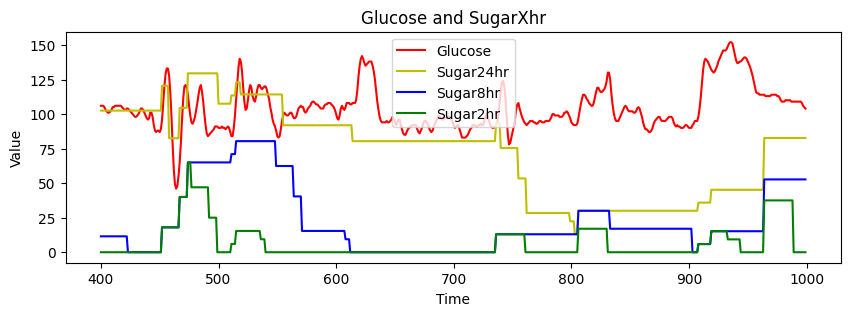

In [15]:
import matplotlib.pyplot as plt

# 날짜 필터링
filtered_df = df.iloc[400:1000]

# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(filtered_df.index, filtered_df['glucose'], 'r', label='Glucose')
plt.plot(filtered_df.index, filtered_df['sugar24hr'], 'y', label='Sugar24hr')
plt.plot(filtered_df.index, filtered_df['sugar8hr'], 'b', label='Sugar8hr')
plt.plot(filtered_df.index, filtered_df['sugar2hr'], 'g', label='Sugar2hr')

plt.title('Glucose and SugarXhr')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

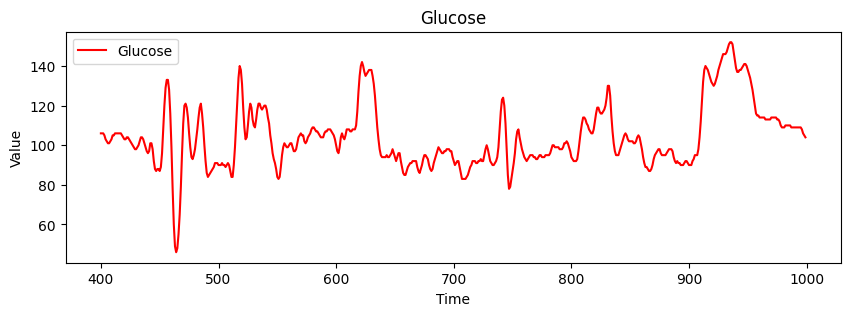

In [16]:
# 날짜 필터링
filtered_df = df.iloc[400:1000]

# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(filtered_df.index, filtered_df['glucose'], 'r', label='Glucose')

plt.title('Glucose')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

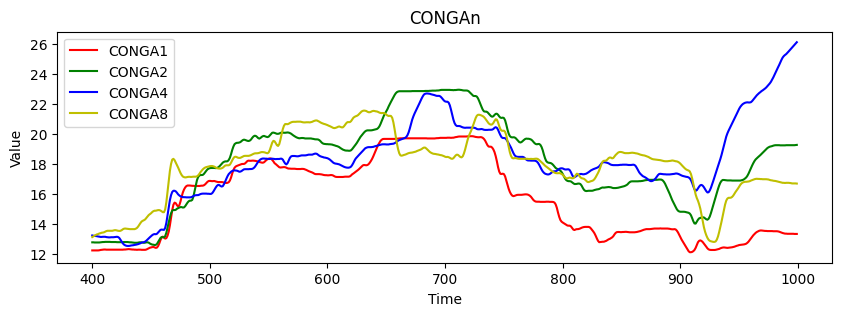

In [17]:
# 날짜 필터링
filtered_df = df.iloc[400:1000]

# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(filtered_df.index, filtered_df['CONGA1'], 'r', label='CONGA1')
plt.plot(filtered_df.index, filtered_df['CONGA2'], 'g', label='CONGA2')
plt.plot(filtered_df.index, filtered_df['CONGA4'], 'b', label='CONGA4')
plt.plot(filtered_df.index, filtered_df['CONGA8'], 'y', label='CONGA8')

plt.title('CONGAn')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

----------------------

## Feature Normalization

횟수 관련 features도 normalization이 필요할까? => 일단 현재에선 정규화 대상에서 제외함.

In [18]:
# 숫자형 feature 컬럼만 선택
feature_cols = df.select_dtypes(include=['number']).columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('glucose')
feature_cols.remove('MAGE')
feature_cols.remove('eat')
feature_cols.remove('eatcnt2hr')
feature_cols.remove('eatcnt8hr')
feature_cols.remove('eatcnt24hr')

if 'Biological Sex' in feature_cols:
    feature_cols.remove('Biological Sex')
if 'label' in feature_cols:
    feature_cols.remove('label')
print(len(feature_cols))
print(feature_cols)

77
['calories2hr', 'protein2hr', 'sugar2hr', 'carbs2hr', 'calories8hr', 'protein8hr', 'sugar8hr', 'carbs8hr', 'calories24hr', 'protein24hr', 'sugar24hr', 'carbs24hr', 'eatmean2hr', 'eatmean8hr', 'eatmean24hr', 'acc_mean', 'acc_std', 'acc_min', 'acc_max', 'acc_q1g', 'acc_q3g', 'acc_skew', 'acc_mean_2hrs', 'acc_max_2hrs', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_q1g', 'eda_q3g', 'eda_skew', 'PeakEDA', 'PeakEDA2hr_sum', 'PeakEDA2hr_mean', 'hr_mean', 'hr_std', 'hr_min', 'hr_max', 'hr_q1g', 'hr_q3g', 'hr_skew', 'maxHRV', 'minHRV', 'medianHRV', 'meanHRV', 'SDNN', 'NN50', 'pNN50', 'RMSSD', 'SDSD', 'CVNN', 'MCVNN', 'SDRMSSD', 'TINN', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_q1g', 'temp_q3g', 'temp_skew', 'Activity_bouts', 'Activity24', 'Activity1hr', 'carbs2hr_ratio', 'protein2hr_ratio', 'sugar2hr_ratio', 'elapsed_minutes_intake', 'CONGA1', 'CONGA2', 'CONGA4', 'CONGA8', 'J_index', 'HBGI', 'LBGI', 'HbA1c', 'CVSD']


In [19]:
# 사용자별 정규화를 수행하는 함수 정의
def user_specific_normalization(df, id_col, feature_cols):
    # 숫자형 feature 컬럼만 선택
    #feature_cols = df.select_dtypes(include=['number']).columns.tolist()
    if id_col in feature_cols:
        feature_cols.remove(id_col)
    
    # 결과를 저장할 데이터 프레임
    normalized_df = pd.DataFrame(columns=df.columns)
    
    # 각 사용자의 데이터를 정규화
    for user_id, group in df.groupby(id_col):
        scaler = StandardScaler()
        # features 부분만 정규화 수행
        normalized_features = scaler.fit_transform(group[feature_cols])
        normalized_group = pd.DataFrame(normalized_features, columns=feature_cols)
        # ID 컬럼과 범주형 컬럼 복사
        normalized_group[id_col] = user_id
        for col in df.columns:
            if col not in feature_cols and col != id_col:
                normalized_group[col] = group[col].values
        normalized_df = pd.concat([normalized_df, normalized_group], ignore_index=True)
    
    return normalized_df

# 사용자별 정규화 수행
normalized_df = user_specific_normalization(df, 'ID', feature_cols=feature_cols)

/tmp/ipykernel_75315/3267098898.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  normalized_df = pd.concat([normalized_df, normalized_group], ignore_index=True)


In [20]:
normalized_df.head(10)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,J_index,HBGI,LBGI,glucose,datetime,ID,HbA1c,Biological Sex,CVSD,label
0,-0.566808,-0.456796,-0.485186,-0.519183,0.457134,-0.139072,0.083763,-0.356896,0.816272,1.702976,...,-1.231291,-1.188856,2.008051,95.0,2020-02-14 17:28:30,1.0,0.0,FEMALE,0.233542,PersNorm
1,-0.566808,-0.456796,-0.485186,-0.519183,0.457134,-0.139072,0.083763,-0.356896,0.816272,1.702976,...,-1.236946,-1.188856,1.925604,95.0,2020-02-14 17:33:30,1.0,0.0,FEMALE,0.739307,PersNorm
2,-0.566808,-0.456796,-0.485186,-0.519183,0.457134,-0.139072,0.083763,-0.356896,0.816272,1.702976,...,-1.242601,-1.188856,1.822545,95.0,2020-02-14 17:38:30,1.0,0.0,FEMALE,1.076483,PersNorm
3,-0.566808,-0.456796,-0.485186,-0.519183,0.457134,-0.139072,0.083763,-0.356896,0.816272,1.702976,...,-1.253912,-1.188856,1.719486,95.0,2020-02-14 17:43:30,1.0,0.0,FEMALE,1.413660,PersNorm
4,-0.566808,-0.456796,-0.485186,-0.519183,-0.333533,-0.330944,-0.737812,-0.948680,0.816272,1.702976,...,-1.259568,-1.188856,1.637039,92.0,2020-02-14 17:48:31,1.0,0.0,FEMALE,-0.272223,PersNorm
5,-0.566808,-0.456796,-0.485186,-0.519183,-0.333533,-0.330944,-0.737812,-0.948680,0.816272,1.702976,...,-1.265223,-1.188856,1.554592,88.0,2020-02-14 17:53:30,1.0,0.0,FEMALE,0.064954,PersNorm
6,-0.566808,-0.456796,-0.485186,-0.519183,-0.333533,-0.330944,-0.737812,-0.948680,0.816272,1.702976,...,-1.270879,-1.188856,1.513368,84.0,2020-02-14 17:58:30,1.0,0.0,FEMALE,0.233542,PersLow
7,-0.566808,-0.456796,-0.485186,-0.519183,-0.333533,-0.330944,-0.737812,-0.948680,0.816272,1.702976,...,-1.276534,-1.188856,1.472145,85.0,2020-02-14 18:03:30,1.0,0.0,FEMALE,-0.272223,PersNorm
8,-0.566808,-0.456796,-0.485186,-0.519183,-0.333533,-0.330944,-0.737812,-0.948680,-0.216182,1.118463,...,-1.282190,-1.188856,1.410309,89.0,2020-02-14 18:08:30,1.0,0.0,FEMALE,0.064954,PersNorm
9,-0.566808,-0.456796,-0.485186,-0.519183,-0.333533,-0.330944,-0.737812,-0.948680,-0.216182,1.118463,...,-1.293501,-1.188856,1.307251,93.0,2020-02-14 18:13:30,1.0,0.0,FEMALE,0.233542,PersNorm


In [21]:
if 'rolling_slope' in df.columns.tolist():
    df.drop(columns=['rolling_slope'], inplace = True)
if 'rolling_slope' in normalized_df.columns.tolist():
    normalized_df.drop(columns=['rolling_slope'], inplace = True)

In [22]:
df.to_csv(r'./features.csv', sep='\t', encoding='utf-8', header='true')
normalized_df.to_csv(r'./normalized_features.csv', sep='\t', encoding='utf-8', header='true')

In [23]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [24]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [25]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
ID                0
HbA1c             0
Biological Sex    0
CVSD              0
label             0
Length: 89, dtype: int64

In [26]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [27]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

## ID별 데이터 비율

ID
11.0    8.232842
6.0     8.203977
1.0     7.408595
5.0     7.322001
8.0     7.296344
3.0     6.494548
9.0     6.468890
2.0     6.407954
7.0     6.401539
10.0    6.385504
4.0     6.308531
12.0    6.144965
14.0    5.968570
16.0    5.538807
13.0    5.416934
Name: proportion, dtype: float64


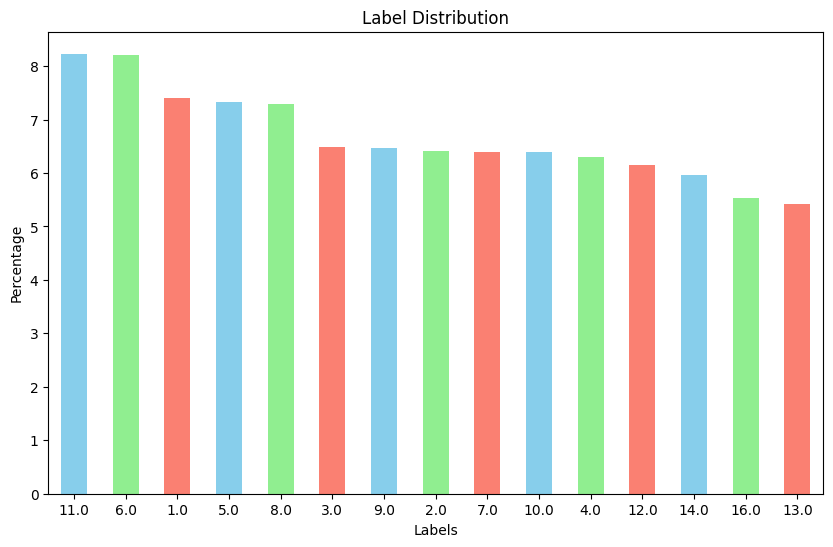

In [28]:
label_distribution = df['ID'].value_counts(normalize=True) * 100
print(label_distribution)

plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

7일의 데이터를 얻으려면 최소 2016개 이상의 5분 간격 데이터가 필요

In [29]:
df['ID'].value_counts()

ID
11.0    2567
6.0     2558
1.0     2310
5.0     2283
8.0     2275
3.0     2025
9.0     2017
2.0     1998
7.0     1996
10.0    1991
4.0     1967
12.0    1916
14.0    1861
16.0    1727
13.0    1689
Name: count, dtype: int64

In [30]:
for id in df['ID'].unique():
    print(f'ID: {id}')
    print(f"\tStart: {df[df['ID'] == id]['datetime'].iloc[0]}")
    print(f"\tEnd: {df[df['ID'] == id]['datetime'].iloc[-1]}")
    data_points = len(df[df['ID'] == id])
    points_per_day = (24 * 60) / 5
    days = data_points / points_per_day
    print(f'\tdays: {days}')


ID: 1.0
	Start: 2020-02-14 17:28:30
	End: 2020-02-22 17:53:23
	days: 8.020833333333334
ID: 2.0
	Start: 2020-02-22 11:13:34
	End: 2020-02-29 09:38:24
	days: 6.9375
ID: 3.0
	Start: 2020-02-23 10:56:44
	End: 2020-03-01 11:36:31
	days: 7.03125
ID: 4.0
	Start: 2020-02-28 11:01:19
	End: 2020-03-06 06:51:06
	days: 6.829861111111111
ID: 5.0
	Start: 2020-02-28 13:40:09
	End: 2020-03-07 11:46:05
	days: 7.927083333333333
ID: 6.0
	Start: 2020-02-29 12:23:11
	End: 2020-03-09 09:27:51
	days: 8.881944444444445
ID: 7.0
	Start: 2020-03-15 12:52:15
	End: 2020-03-22 11:06:57
	days: 6.930555555555555
ID: 8.0
	Start: 2020-03-15 14:14:50
	End: 2020-03-23 11:39:31
	days: 7.899305555555555
ID: 9.0
	Start: 2020-03-22 11:01:49
	End: 2020-03-29 11:01:41
	days: 7.003472222222222
ID: 10.0
	Start: 2020-03-23 11:34:16
	End: 2020-03-30 09:19:02
	days: 6.913194444444445
ID: 11.0
	Start: 2020-04-07 09:36:06
	End: 2020-04-16 07:20:51
	days: 8.913194444444445
ID: 12.0
	Start: 2020-05-04 18:02:11
	End: 2020-05-11 09:31:59

## 상관관계 Matrix Heat map

In [31]:
corrdf = df.drop(columns=['datetime']).corr()

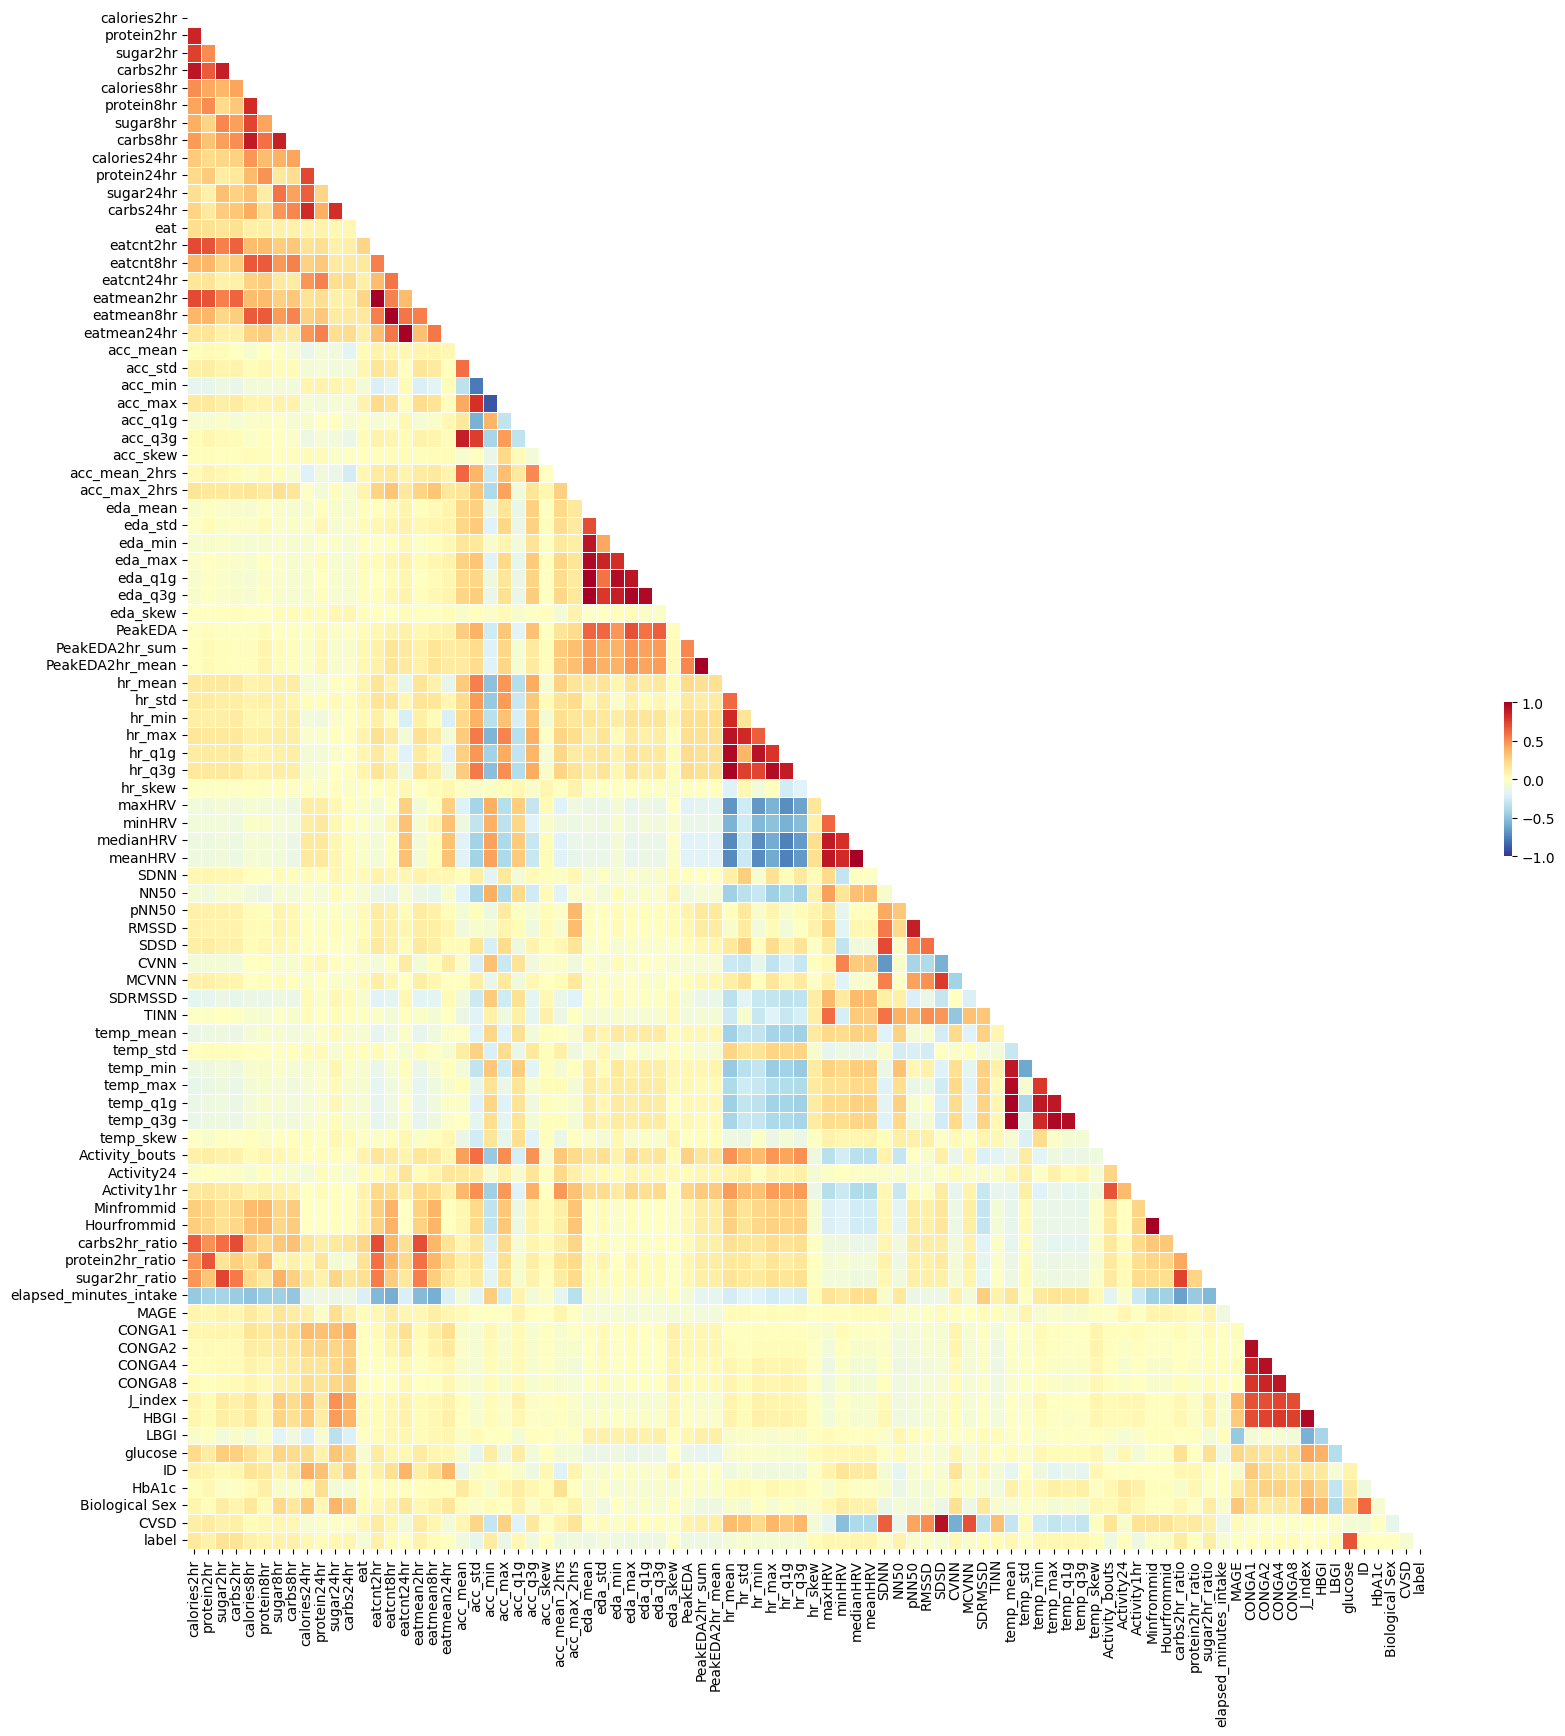

In [32]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()